In [1]:
# install packages


# import packages

import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import pickle
#hmm
from hmmlearn import hmm



# format

# def stock_data(stock_name -> str):

# Return train_data, test_data 


# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 


# def evaluation(test_data -> np.array, prediction -> np.array):
	
# 	Return metrics


# evaluation

In [2]:
def reject_outliers(data, m=1.5):
    ceiling = np.mean(data)+ m * np.std(data)
    floor = np.mean(data)- m * np.std(data)
    
    return np.clip(data,a_min = floor, a_max = ceiling)

In [3]:
def evaluation_metrics(test_data, predictions,take_abs = True):
    
    if take_abs:
        test_data = np.abs(test_data)
        predictions = np.abs(predictions)
    metrics = {}
    
    metrics['MAPE'] = mean_absolute_percentage_error(predictions,test_data)
    metrics['MSE'] = mean_squared_error(test_data,predictions)
    
    return metrics

# Models

In [4]:
def hmm_prediction(train_data,num_of_predictions):
    hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
    hmm_model.fit(train_data)
    
    predict_state = hmm_model.predict(train_data)
    
    hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
    hmm_prediction_value = hmm_prediction[0]
    hmm_prediction_states = hmm_prediction[1]
    
    return hmm_prediction_value

# Pipeline

In [5]:
a_file = open('processed_data/' + 'micro' + '_test.pkl', "rb")
test_data = pickle.load(a_file)

In [6]:
pd.DataFrame(test_data['NH'])

,0,1
0,2021-01-04,-0.050381
1,2021-01-05,0.029328
2,2021-01-06,-0.055007
3,2021-01-07,-0.033244
4,2021-01-08,0.085279
...,...,...
232,2021-12-03,-0.019418
233,2021-12-06,-0.05609
234,2021-12-07,0.0
235,2021-12-08,0.037041


In [7]:
cap_list = ['nano','micro','small','medium','large','mega']

In [8]:
metrics_df_concat = pd.DataFrame()

for cap_size in cap_list:
    result_metric_dict = {}
    
    a_file = open('processed_data/' + cap_size + '_train.pkl', "rb")
    train_data = pickle.load(a_file)
    
    a_file = open('processed_data/' + cap_size + '_test.pkl', "rb")
    test_data = pickle.load(a_file)
    
    
    for stock_ticker in train_data.keys():
        #print(stock_ticker)
        model_input = np.array(pd.DataFrame(train_data[stock_ticker]).dropna()[1])
        actual_values = np.array(pd.DataFrame(test_data[stock_ticker]).dropna()[1])
        
        prediction = hmm_prediction(model_input.reshape(-1,1),len(actual_values))
        result_metric_dict[stock_ticker] = evaluation_metrics(actual_values.reshape(-1,1),prediction)

    metrics_df = pd.DataFrame(result_metric_dict).T
    metrics_df['Cap_size'] = cap_size
    
    metrics_df_concat = metrics_df_concat.append(metrics_df)

In [9]:
metrics_df_concat

,MAPE,MSE,Cap_size
WVVIP,6.857298,0.000919,nano
CBIO,1.690550,0.002318,nano
CYCCP,9.139780,0.002535,nano
CLRB,5.147440,0.002733,nano
NSYS,8.000481,0.002489,nano
...,...,...,...
CSCO,4.086059,0.000322,mega
CMCSA,2.622136,0.000371,mega
INTC,2.968266,0.000541,mega
NFLX,2.626885,0.000502,mega


#  MAPE by cap

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

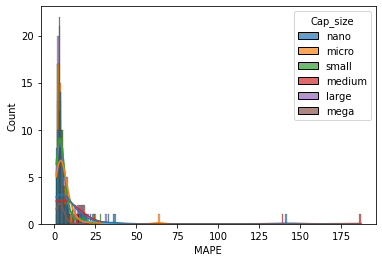

In [10]:
sns.histplot(data = metrics_df_concat
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

Text(0, 0.5, 'Cap Size')

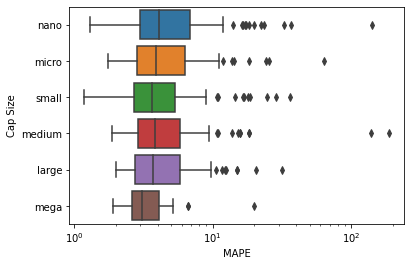

In [11]:
sns.boxplot(data = metrics_df_concat
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
plt.xscale('log')
plt.ylabel('Cap Size')

In [12]:
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

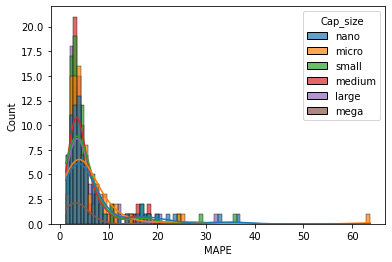

In [13]:
sns.histplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

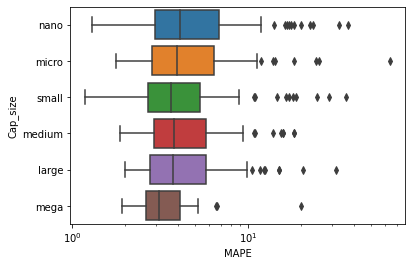

In [19]:
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size' 
            )
plt.xscale('log')


# MSE by cap

Text(0, 0.5, 'Cap Size')

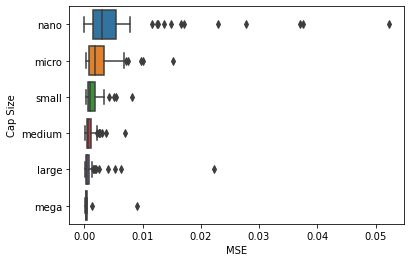

In [15]:
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MSE'
            ,y = 'Cap_size'
            )
plt.ylabel('Cap Size')

# statistics

In [16]:
metrics_df_concat.groupby('Cap_size').mean().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,8.248564,0.005964
micro,6.049290,0.002655
small,5.528778,0.001454
medium,8.716597,0.000993
large,5.291710,0.001061
mega,4.370087,0.000859


In [17]:
metrics_df_concat.groupby('Cap_size').std().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,16.415397,0.008902
micro,7.572413,0.002545
small,5.760910,0.001299
medium,24.325453,0.000955
large,4.551727,0.002627
mega,4.007275,0.002013
